# The Lennard-Jones potential

Ralf Everaers, ENS Lyon (2021-22)

According to Wikipedia [https://en.wikipedia.org/wiki/Lennard-Jones_potential]:

"The Lennard-Jones potential is a simplified model that yet describes the essential features of interactions between simple atoms and molecules: Two interacting particles repel each other at very close distance, attract each other at moderate distance, and do not interact at infinite distance, see figure 1. The Lennard-Jones potential is a pair potential, i.e. no three- or multi-body interactions are covered by the potential.

Statistical mechanics and computer simulations can be used to study the Lennard-Jones potential and to obtain thermophysical properties of the 'Lennard-Jones substance'. Both the Lennard-Jones potential and, accordingly, the Lennard-Jones substance are simplified yet realistic models, such as they accurately capture essential physical principles like the presence of a critical and a triple point, condensation and freezing. The Lennard-Jones potential is mathematically simple and is therefore extensively used in studies on matter since the early days of computer simulation. Due to its mathematical simplicity and generic modeling capabilities, the Lennard-Jones potential is probably still the most frequently studied model potential. The Lennard-Jones substance is often even referred to as 'Lennard-Jonesium', suggesting that it is viewed as a chemical element. The Lennard-Jones potential is usually the standard choice for the development of theories for matter (especially soft-matter) as well as for the development and testing of computational methods and algorithms. Upon adjusting the model parameters $\epsilon$ and $\sigma$ to real substance properties, the Lennard-Jones potential can be used to describe simple substance (like noble gases) with good accuracy. Furthermore, the Lennard-Jones potential is often used as a building block in molecular models (a.k.a. force fields) for more complex substances."

In [1]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## Functional form

The Lennard-Jones potential with the functional form

\begin{equation}
U_{LJ}(r) = 4\epsilon \left(\left(\frac\sigma{r}\right)^{12} - \left(\frac\sigma{r}\right)^6 \right)
\end{equation}

provides a reasonable description of the interaction between noble gas atoms and is widely used in Molecular Dynamics simulations to represent the excluded volume and van der Waals interactions between atoms of all types.

Text(0, 0.5, '$U_{LJ}(r)/\\epsilon$')

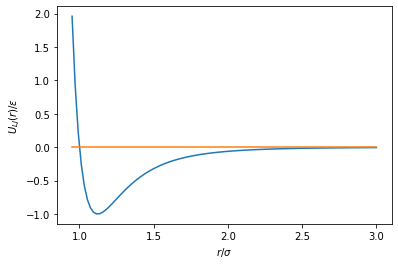

In [2]:
r = np.linspace(0.95,3,100)
u = 4*(r**(-12)-r**-6)
plt.plot(r,u)
plt.plot(r,0*r)
plt.xlabel("$r/\sigma$")
plt.ylabel("$U_{LJ}(r)/\epsilon$")

The corresponding forces on two particles $i$ and $j$ located at $\vec r_i$ and $\vec r_j$ at a mutual distance of $r_{ij}=|\vec r_i-\vec r_j|$ are given by

\begin{equation}
-\frac d{d \vec r_i} U_{LJ}(r_{ij}) = 24\epsilon \left(2\left(\frac\sigma{r_{ij}}\right)^{12} - \left(\frac\sigma{r_{ij}}\right)^6 \right) \frac{\vec r_i-\vec r_j}{r_{ij}^2}
\end{equation}


Text(0, 0.5, '$f_{LJ}(r)/ (\\epsilon/\\sigma)$')

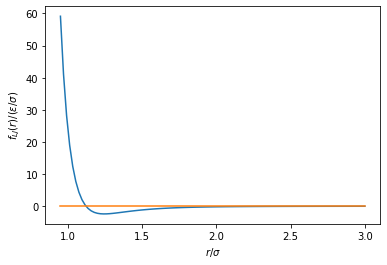

In [3]:
r = np.linspace(0.95,3,100)
f = 24*(2*r**(-12)-r**-6)/r
plt.plot(r,f)
plt.plot(r,0*r)
plt.xlabel("$r/\sigma$")
plt.ylabel("$f_{LJ}(r)/ (\epsilon/\sigma)$")

### Routine for calculating the Lennard-Jones energy for an array of distance vectors

In [4]:
def U_LJ(d,epsilon,sigma,distance_vector):
    """
    Lennard-Jones potential energy in d dimensions
    
    d is the embedding dimension. Needed to distinguish the case of 2 1d distance vectors from 1 2d distance vector.
    
    epsilon is the energy scale of the LJ potential and can be
        a scalar for a single interaction or if all interactions have the same epsilon
        an array of the length of the array of distance vectors
        
    sigma is the interaction range and can be
        a scalar for a single interaction or if all interactions have the same epsilon
        an array of the length of the array of distance vectors

    distance_vector are the instanteneous distances 
        in d = 1 distance_vector = delta_x
        in d>1 distance_vector has to be of the form distance_vector = (delta_x,delta_x) or distance_vector = [delta_x,delta_x]
        where delta_x and delta_y can be    
            a scalar for a single interaction
            an array for several interactions to be evaluated simultaneously

    The function returns 4*epsilon*((sigma/r)**(-12)-(sigma/r)**-6) where u has the same format as delta_x
    """
    eps = np.array(epsilon)       
    sig = np.array(sigma)       
    delta_r = np.array(distance_vector)                   # array of scalar(d=1) or vector (d>1) distances
    delta_r_sqr = delta_r**2                              # array of Cartesian components of squared distances
    if d > 1:
        delta_r_sqr = np.sum(delta_r_sqr,axis=0)         # add up Cartesian components in d>1
    relative_inverse_squared_distance = sigma**2/delta_r_sqr
    u = 4*epsilon*(relative_inverse_squared_distance**6-relative_inverse_squared_distance**3)
    return u

Here is a test that the function works with our different data types

In [5]:
r=2**(1./6)
r=1.2
print("target value: \n",4*(r**(-12)-r**-6))

# single distance
x = r
y = 0
print(" \n Single distance 1d \n",U_LJ(1,1,1,x))
print("Single distance 2d \n",U_LJ(2,1,1,(x,y)))

# a configuration or list of distances 
x = [x,x,x,x]
y = [y,y,y,y]
print(" \n Configuration 1d \n",U_LJ(1,1,1,x)[0])
print("Configuration 2d \n",U_LJ(2,1,1,(x,y))[0])

# a trajectory or list of configurations 
x_tr = np.array([x,x,x])
y_tr = np.array([y,y,y])
print(" \n Trajectory 1d \n",U_LJ(1,1,1,x_tr)[0,0])
print("Trajectory 2d \n",U_LJ(2,1,1,(x_tr,y_tr))[0,0])

# an ensemble or list of trajectories
x_tr_ens = np.array([x_tr,x_tr])
y_tr_ens = np.array([y_tr,y_tr])
print(" \n Ensemble of trajectories 1d \n",U_LJ(1,1,1,x_tr_ens)[0,0,0])
print("LEnsemble of trajectories 2d \n",U_LJ(2,1,1,(x_tr_ens,y_tr_ens))[0,0,0])


target value: 
 -0.8909652875830762
 
 Single distance 1d 
 -0.890965287583076
Single distance 2d 
 -0.890965287583076
 
 Configuration 1d 
 -0.890965287583076
Configuration 2d 
 -0.890965287583076
 
 Trajectory 1d 
 -0.890965287583076
Trajectory 2d 
 -0.890965287583076
 
 Ensemble of trajectories 1d 
 -0.890965287583076
LEnsemble of trajectories 2d 
 -0.890965287583076


### Routine for calculating the Lennard-Jones force for an array of distance vectors

In [6]:
def f_LJ(d,epsilon,sigma,distance_vector,debug=False):
    """
    Lennard-Jones force in d dimensions
    
    d is the embedding dimension. Needed to distinguish the case of 2 1d distance vectors from 1 2d distance vector.
    
    epsilon is the energy scale of the LJ potential and can be
        a scalar for a single interaction or if all interactions have the same epsilon
        an array of the length of the array of distance vectors
        
    sigma is the interaction range and can be
        a scalar for a single interaction or if all interactions have the same epsilon
        an array of the length of the array of distance vectors

    distance_vector are the instanteneous distances 
        in d = 1 distance_vector = delta_x
        in d>1 distance_vector has to be of the form distance_vector = (delta_x,delta_x) or distance_vector = [delta_x,delta_x]
        where delta_x and delta_y can be    
            a scalar for a single interaction
            an array for several interactions to be evaluated simultaneously

    The function returns -24*epsilon*(2*(sigma/r)**(-12)-(sigma/r)**-6) * distance_vector/r**2 
        where f has the same format as distance_vector
        and r = |distance_vector|
    """
    eps = np.array(epsilon)       
    sig = np.array(sigma)       
    delta_r = np.array(distance_vector)       # array of scalar(d=1) or vector (d>1) distances
    if debug: 
        print(delta_r)
    delta_r_sqr = delta_r**2                              # array of Cartesian components of squared distances
    if d > 1:
        delta_r_sqr = np.sum(delta_r_sqr,axis=0)         # add up Cartesian components in d>1
    relative_inverse_squared_distance = sigma**2/delta_r_sqr
    f = 24*epsilon*(2*relative_inverse_squared_distance**6-relative_inverse_squared_distance**3)/delta_r_sqr*delta_r
    return f

In [7]:
r=2**(1./6)
r=1.2
print("target value: \n",24*(2*r**(-12)-r**-6)/r)

# single distance
x = r
y = 0
print(" \n Single distance 1d \n",f_LJ(1,1,1,x))
print("Single distance 2d \n",f_LJ(2,1,1,(x,y)))

# a configuration or list of distances 
x = [x,x,x,x]
y = [y,y,y,y]
print(" \n Configuration 1d \n",f_LJ(1,1,1,x)[0])
print("Configuration 2d \n",f_LJ(2,1,1,(x,y))[0,0],f_LJ(2,1,1,(x,y))[1,0])

# a trajectory or list of configurations 
x_tr = np.array([x,x,x])
y_tr = np.array([y,y,y])
print(" \n Trajectory 1d \n",f_LJ(1,1,1,x_tr)[0,0])
print("Trajectory 2d \n",f_LJ(2,1,1,(x_tr,y_tr))[0,0,0],f_LJ(2,1,1,(x_tr,y_tr))[1,0,0])

# an ensemble or list of trajectories
x_tr_ens = np.array([x_tr,x_tr])
y_tr_ens = np.array([y_tr,y_tr])
print(" \n Ensemble of trajectories 1d \n",f_LJ(1,1,1,x_tr_ens)[0,0,0])
print("Ensemble of trajectories 2d \n",f_LJ(2,1,1,(x_tr_ens,y_tr_ens))[0,0,0,0],f_LJ(2,1,1,(x_tr_ens,y_tr_ens))[1,0,0,0])


target value: 
 -2.2116933422230787
 
 Single distance 1d 
 -2.2116933422230787
Single distance 2d 
 [-2.21169334 -0.        ]
 
 Configuration 1d 
 -2.2116933422230787
Configuration 2d 
 -2.2116933422230787 -0.0
 
 Trajectory 1d 
 -2.2116933422230787
Trajectory 2d 
 -2.2116933422230787 -0.0
 
 Ensemble of trajectories 1d 
 -2.2116933422230787
Ensemble of trajectories 2d 
 -2.2116933422230787 -0.0


## Starting state

We can no longer initiate our systems with particles placed at random positions (why?). Instead we place them on a regular square grid, i.e. an unstable configuration which does NOT correspond to a metastable crystal lattice.

In [8]:
np.arange(10)//3

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3])

In [10]:
def GridPositionsIn2d(xBox,yBox,NParticles,debug=False):
    """
    Returns two arrays of x- and y-positions for NParticles in the interval 
        xBox = [xmin,xmax) or xBox * [0,1), if xBox is a float or integer
        yBox = [xmin,xmax) or xBox * [0,1), if xBox is a float or integer
    """
    n = np.ceil(np.sqrt(NParticles))            # number of particles in a row or column of our square grid
    (xmin, xmax, XBox) = MD.BoxDimensions(xBox)
    ax = XBox / n
    (ymin, ymax, YBox) = MD.BoxDimensions(yBox)
    ay = XBox / n
    
    if debug:
        print("Lattice constant: ",ax,ay)
    
    x = MD.FoldIntoBox(xBox,xmin+ax*(np.arange(NParticles)+0.5))
    y = ymin+ ay*(np.arange(NParticles)//n+0.5)
        
    return x,y

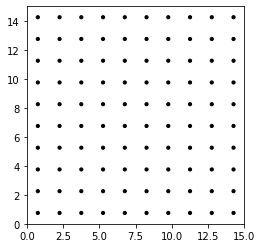

In [11]:
NParticles=100
LBox = 15
x,y = GridPositionsIn2d(LBox,LBox,NParticles)
MD.PlotMDConf(x,y,xBox=LBox,yBox=LBox)

## Forces and interaction energies as a function of the position of all particles in the system

To calculate the total force acting on a particle in a LJ system we need to

    1) deal with periodic boundary conditions in calculating particle distances
    2) loop over all particle pairs

### Minimum image convention

We are going to use the familiar periodic boundary conditions. So far, we have only worried about how to "fold" the positions of freely moving particles back into the box, i.e. how to locate the appropriate periodic image of the particles we follow in the central/original simulation box. 

Text(0, 0.5, 'folded position')

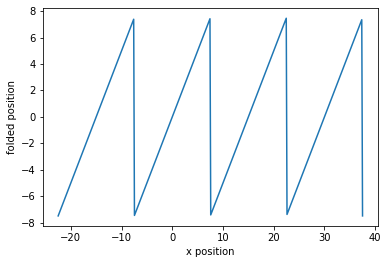

In [13]:
test_x = np.linspace(-1.5*LBox,2.5*LBox,400)
xmin = -0.5*LBox
plt.plot(test_x,MD.FoldIntoBox((xmin,xmin+LBox),test_x))
plt.xlabel("x position")
plt.ylabel("folded position")

Note that our function allowed us to arbitrarily set the absolute position of the simulation box:

Text(0, 0.5, 'folded position')

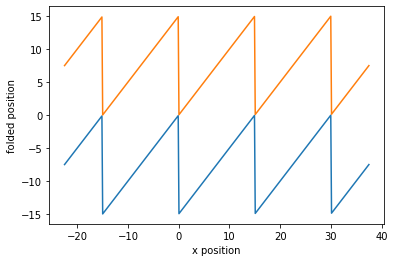

In [14]:
test_x = np.linspace(-1.5*LBox,2.5*LBox,400)
offset_steps = 1
# quickly look at the result of choosing other (small) integer values!
for offset in range(-offset_steps,offset_steps):
    xmin = 1.*offset*LBox/offset_steps
    plt.plot(test_x,MD.FoldIntoBox((xmin,xmin+LBox),test_x))
plt.xlabel("x position")
plt.ylabel("folded position")

Obviously such a shift has/should have no impact on our results other than allowing us to locate an interesting zone such as an interface in the center of our animations. 

Now we have to extend the argument to distance vectors between particles with pair interactions, whose spatial range is shorter than one half of the box size. In this case, a particle interacts at most with the one image of a second particle, which is located closest to it in space.

In [15]:
def MinimumImage(xBox,dx):
    (xmin, xmax, LBox) = MD.BoxDimensions(xBox)
    return dx - np.rint(dx/LBox)*LBox

In particular, the result of this operation has to be independent of whether or not (and if so, with which offset) we fold the particle positions into the box prior to calculating the interparticle distance using the minimum image convention!

Text(0, 0.5, 'minimum image')

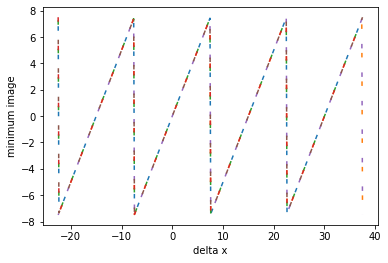

In [16]:
#assume that particle 1 is located at x=0
test_x1 = 0
test_x2 = np.linspace(-1.5*LBox,2.5*LBox,400)
offset_steps = 3
# quickly look at the result of choosing other (small) integer values!
for offset in range(-offset_steps,offset_steps):
    xmin = 1.*offset*LBox/offset_steps
    folded_test_x1 = MD.FoldIntoBox((xmin,xmin+LBox),test_x1)
    folded_test_x2 = MD.FoldIntoBox((xmin,xmin+LBox),test_x2)
    plt.plot(test_x,MinimumImage((xmin,xmin+LBox),folded_test_x2-folded_test_x1), linestyle=(2*offset, (3,16)))
plt.xlabel("delta x")
plt.ylabel("minimum image")

Make sure that you understand the maximal possible value!

### Looping over all pairs of particles

#### Naive version

In their simplest and numerically most inefficient version we could implement the following functions with a double loop over all particles:

    for i in range(NParticles):

        for j in range(i):
        #avoids double counting
    
        #pair interaction
        calculate delta_r_ij
        calculate f_ij = f_LJ(delta_r_ij)
        calculate u_ij = U_LJ(delta_r_ij)
    
        #add to total force acting on the individual particles
        f_i += f_ij
        f_j -= f_ij    
    
        #add to total interaction energy of the individual particles
        u_i += u_ij
        u_j += u_ij
    
        #note the different signs for adding up f_j and u_j!

In [17]:
def LJ_forces_as_a_function_of_positions(d,epsilon,sigma,LBox,r,debug=False):
    """
    returns the LJ force acting on each particle as a function of the positions of all particles
    """
    r = np.array(r)
    N = r.shape[-1]
    r = r.transpose()    # so that r[0] = [x[0],y[0]]
    f = 0*np.copy(r)     # initialise force array with the same shape as position array
    
    if debug:
        print(N)
    
    for i in range(1,N):

        for j in range(i):
        #avoids double counting
    
            #pair interaction
            delta_r_ij = MinimumImage(LBox,r[i]-r[j])
            f_ij = f_LJ(d,epsilon,sigma,delta_r_ij)
    
            #add to total force acting on the individual particles
            f[i] += f_ij
            f[j] -= f_ij    
        
            #note the different signs for adding up f_j and u_j!    
            
    return f.transpose()  # return [fx,fy]

In [18]:
def LJ_energies_as_a_function_of_positions(d,epsilon,sigma,LBox,r,debug=False):
    """
    returns the LJ interaction energy for each particle as a function of the positions of all particles
    """
    r = np.array(r)
    if d==1:
        u = 0*np.copy(r)     # initialise energy array with the same shape as the d=1 position array
    else:
        u = 0*np.copy(r[0])  # initialise energy array with the same shape as the first Cartesian component
                             # of the position array
    N = r.shape[-1]
    r = r.transpose()        # so that r[0] = [x[0],y[0]]
    
    if debug:
        print(N)
    
    for i in range(1,N):

        for j in range(i):
        #avoids double counting
    
            #pair interaction
            delta_r_ij = MinimumImage(LBox,r[i]-r[j])
            u_ij = U_LJ(d,epsilon,sigma,delta_r_ij)
    
            #add to total interaction energy of the individual particles
            u[i] += u_ij/2
            u[j] += u_ij/2    
        
            #note the factor of 1/2 and the different signs for adding up f_j and u_j!    
            
    return u  


def LJ_energy_as_a_function_of_positions(d,epsilon,sigma,LBox,r):
    """
    returns the total LJ interaction energy as a function of the positions of all particles
    """
    return np.sum(LJ_energies_as_a_function_of_positions(d,epsilon,sigma,LBox,r))

We will write faster code below, so let's quickly measure how long it takes to calculate the forces with the present routines:

In [19]:
NParticles=900
# net forces around missing particle
LBox = 80
x,y = GridPositionsIn2d(LBox,LBox,NParticles)

# to measure the computer time needed to calculate the ensemble of trajectory
initialWallTime = time.perf_counter()

for i in range(10):
    fx,fy = LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x,y))

print("Execution time: ",time.perf_counter() - initialWallTime)

Execution time:  105.86411603999977


### Your turn: vary the number of particles and the density and explore the effect on the LJ energy and forces

If a completely filled lattice, the interparticle forces add up to zero by symmetry and construction.

It is nevertheless instructive to calculate the interaction energy for box sizes where the lattice constant is close to the minimum a = 2**(1/6) sigma of the LJ potential.

Total energy:  -188.30821062850688


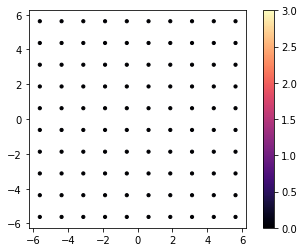

In [20]:
NParticles=100
# net forces around missing particle
LBox = 12.5
x,y = GridPositionsIn2d(LBox,LBox,NParticles)
fx,fy = LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x,y))
u = LJ_energies_as_a_function_of_positions(2,1.,1.,LBox,(x,y))
print("Total energy: ",np.sum(u))
MD.PlotMDConfWithAssociated2dVectors(x,y,fx,fy,xBox=(-LBox/2,LBox/2),xpbc=True,yBox=(-LBox/2,LBox/2),ypbc=True,c=u)

It is more interesting to analyse the forces in the case of a missing atom. 

Look at the result fo the same range of box sizes  and make sure, that we have not mixed up the sign of the calculated forces!

Total energy:  -261.4370327504585


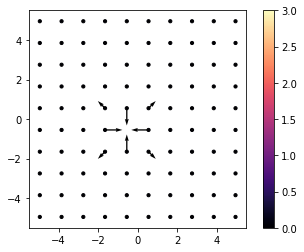

In [21]:
NParticles=99
# net forces around missing particle
LBox = 11.
x,y = GridPositionsIn2d(LBox,LBox,NParticles)
fx,fy = LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x,y))
u = LJ_energies_as_a_function_of_positions(2,1.,1.,LBox,(x,y))
print("Total energy: ",np.sum(u))
MD.PlotMDConfWithAssociated2dVectors(x,y,fx,fy,xBox=(-LBox/2,LBox/2),xpbc=True,yBox=(-LBox/2,LBox/2),ypbc=True,c=u)

### Faster versions of the force and energy routines using NumPy arrays

We can obtain much faster code uing NumPy ability to perform rapid calculations with arrays. 

In [22]:
N=4
indices = np.arange(0,N)
for k in range(1,N):
    print(np.array([indices,np.roll(indices,k)]).transpose())

[[0 3]
 [1 0]
 [2 1]
 [3 2]]
[[0 2]
 [1 3]
 [2 0]
 [3 1]]
[[0 1]
 [1 2]
 [2 3]
 [3 0]]


In [23]:
def LJ_forces_as_a_function_of_positions(d,epsilon,sigma,LBox,r,debug=False):
    """
    returns the LJ force acting on each particle as a function of the positions of all particles
    """
    r = np.array(r)
    N = r.shape[-1]
    f = 0*np.copy(r) #initialise force array with the same shape as position array
    
    if debug:
        print(N)
    
    for k in range(1,N):
        delta_r_pair = MinimumImage(LBox,r-np.roll(r,k,axis=-1))
        fpair = f_LJ(d,epsilon,sigma,delta_r_pair)
        f += fpair
        f -= np.roll(fpair,-k,axis=-1)
    return f/2

In [24]:
def LJ_energies_as_a_function_of_positions(d,epsilon,sigma,LBox,r,debug=False):
    """
    returns the LJ interaction energy for each particle as a function of the positions of all particles
    """
    r = np.array(r)
    if d==1:
        u = 0*np.copy(r)     # initialise energy array with the same shape as the d=1 position array
    else:
        u = 0*np.copy(r[0])  # initialise energy array with the same shape as the first Cartesian component
                             # of the position array
    N = r.shape[-1]
    
    if(debug):
        print(N,NParticles,epsilon,sigma)
    
    for k in range(1,N):
        delta_r_pair = MinimumImage(LBox,r-np.roll(r,k,axis=-1))
        upair = U_LJ(d,epsilon,sigma,delta_r_pair)
        u += upair/2
        u += np.roll(upair,-k,axis=-1)/2
    return u/2

def LJ_energy_as_a_function_of_positions(d,epsilon,sigma,LBox,r):
    """
    returns the total LJ interaction energy as a function of the positions of all particles
    """
    return np.sum(LJ_energies_as_a_function_of_positions(d,epsilon,sigma,LBox,r),axis=-1)

Let's first check, that we obtain the same results as before!

99
Total energy:  -261.4370327504583
Total energy:  -261.4370327504583


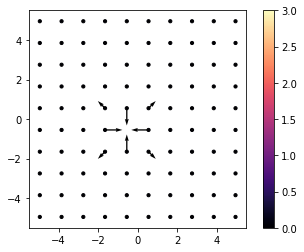

In [25]:
NParticles=99
# net forces around missing particle
LBox = 11
x,y = GridPositionsIn2d(LBox,LBox,NParticles)
fx,fy = LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x,y),debug=True)
u = LJ_energies_as_a_function_of_positions(2,1.,1.,LBox,(x,y))
print("Total energy: ",np.sum(u))
print("Total energy: ",LJ_energy_as_a_function_of_positions(2,1.,1.,LBox,(x,y)))
MD.PlotMDConfWithAssociated2dVectors(x,y,fx,fy,xBox=(-LBox/2,LBox/2),xpbc=True,yBox=(-LBox/2,LBox/2),ypbc=True,c=u)

This being so we can compare the numerical performance:

In [26]:
NParticles=900
LBox = 80
x,y = GridPositionsIn2d(LBox,LBox,NParticles)

# to measure the computer time needed to calculate the ensemble of trajectory
initialWallTime = time.perf_counter()

for i in range(10):
    fx,fy = LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x,y))

print("Execution time: ",time.perf_counter() - initialWallTime)

Execution time:  1.089165591999972


Almost 100 times faster for 900 particles. And the more, for larger the systems!

And as an added benefit these functions can be directly applied to trajectories or ensembles of trajectories

In [27]:
NParticles=99
# net forces around missing particle
LBox = 11

# a single configuration
x,y = GridPositionsIn2d(LBox,LBox,NParticles)
(fx,fy)=LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x,y))
print("Force on particle 0: ",fx[0],fy[0])
print("Total energy: ",LJ_energy_as_a_function_of_positions(2,1.,1.,LBox,(x,y)))

# trajectory: list of list of distances 
x_tr = np.array([x,x,x])
y_tr = np.array([y,y,y])
(fx_tr,fy_tr)=LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x_tr,y_tr))
print("\n Force on particle 0: ",fx_tr[0,0],fy_tr[0,0])
print("Total energy: ",LJ_energy_as_a_function_of_positions(2,1.,1.,LBox,(x_tr,y_tr)))

# ensemble of trajectories
x_tr_ens = np.array([x_tr,x_tr])
y_tr_ens = np.array([y_tr,y_tr])
(fx_tr_ens,fy_tr_ens)=LJ_forces_as_a_function_of_positions(2,1.,1.,LBox,(x_tr_ens,y_tr_ens))
print("\n Force on particle 0: ",fx_tr_ens[0,0,0],fy_tr_ens[0,0,0])
print("Total energy: ",LJ_energy_as_a_function_of_positions(2,1.,1.,LBox,(x_tr_ens,y_tr_ens)))


Force on particle 0:  0.6603662003178024 0.6603662003178495
Total energy:  -261.4370327504583

 Force on particle 0:  0.6603662003178024 0.6603662003178495
Total energy:  [-261.43703275 -261.43703275 -261.43703275]

 Force on particle 0:  0.6603662003178024 0.6603662003178495
Total energy:  [[-261.43703275 -261.43703275 -261.43703275]
 [-261.43703275 -261.43703275 -261.43703275]]
